#### Karolina Solarska (410858), Zuzanna Kostecka (420833)

# A Comprehensive Analysis of Elon Musk's Tweeted Topics and Trends

#### Project description
In this project we prepare the data (Elon Musk's tweets) in a way, that will help us to gain most possible information. We will try both removing all the frequent but meaningless words (we will call them stopwords for the simplifaction), and also exploring the NER without removal. The first approach in column ***nostopwords_rootform_text*** will be used for unsupervised learning method of knowledge extraction - clustering. We will try to find out which topics and which specific entities are most frequently raised by the author. The second approach will concern the named entity recognition (NER) analysis. Lastly we will use the topic modelling techniques: Non-Negative Matrix Factorization and Bertopic model. 
<br>
<br>
#### Challenge of the project
The substantial question here would be which approach fit our problem the most and overrides the potential issues related to the language that the author is using. We will assess not only the wuality of the output but also its reproducibility and time consumption.
<br>
<br>
#### Purpose/ object of the analysis
**The main purpose of the project is to confirm or reject the assumption, that Elon Musk, as an important business owner and technology prompter is engaged to the politics, ai topics, his own businesses and moral issues.** We will compare a several approaches in terms of topic modelling performance.

***Table of contents:***
1. Read and cleaning 
2. EDA
3. Clustering
4. NER
5. Topic modelling
6. Conclusion
7. Appendix

In [1]:
import matplotlib.pyplot as plt
import nltk
import nltk.corpus
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from collections import Counter
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
from nltk.tokenize import RegexpTokenizer, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

# download if necessary
# nltk.download('punkt')
# nltk.download('stopwords')

# 1. Dataset description, read and cleaning

The dataset has been sourced from Kaggle: https://www.kaggle.com/code/vencerlanz09/elon-musk-tweets-eda-and-sentiment-analysis/notebook. It contains 5904 tweets of Elon Musk from July 2022 until June 2023. 

In [2]:
tweets = pd.read_csv("Data//elon_musk_tweets.csv")
len(tweets)

5904

#### Drop unnecessary columns

In [3]:
drop_columns = ["user_location", "user_created", "user_friends", "user_favourites", "user_verified","source", "user_location"]
tweets.drop(drop_columns, axis=1, inplace=True)
tweets.head(3)

,id,user_name,user_description,user_followers,date,text,hashtags,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,"Mars & Cars, Chips & Dips",101240855,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock – inevitabl...,NaN,335,6542,False
1,1544377493263720450,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:47:42+00:00,"Sock Con, the conference for socks",NaN,1451,30753,False
2,1544377130590552064,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,1284,28610,False


#### Drop special characters

We do not drop @ since it help us to recognize that author is replying to someone (or just tags an user)

In [4]:
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9@ \n]', '', text)
    cleaned_text = re.sub(r' +', ' ', cleaned_text)
    return cleaned_text

tweets['text'] = tweets['text'].apply(clean_text)
tweets.head(3)


,id,user_name,user_description,user_followers,date,text,hashtags,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,"Mars & Cars, Chips & Dips",101240855,2022-07-05 17:55:09+00:00,@BillyM2k I find the gold toe sock inevitably ...,NaN,335,6542,False
1,1544377493263720450,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:47:42+00:00,Sock Con the conference for socks,NaN,1451,30753,False
2,1544377130590552064,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,1284,28610,False


Let's replace all the @username with "username".

In [5]:
def replace_at_user(text):
    pattern = r'@\w+'
    cleaned_text = re.sub(pattern, 'username', text)
    return cleaned_text

tweets['text'] = tweets['text'].apply(replace_at_user)
tweets.head(3)

,id,user_name,user_description,user_followers,date,text,hashtags,retweets,favorites,is_retweet
0,1544379368478212100,Elon Musk,"Mars & Cars, Chips & Dips",101240855,2022-07-05 17:55:09+00:00,username I find the gold toe sock inevitably o...,NaN,335,6542,False
1,1544377493263720450,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:47:42+00:00,Sock Con the conference for socks,NaN,1451,30753,False
2,1544377130590552064,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,1284,28610,False


#### Remove stopwords - tokenization

In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
def tokenize_text(text):
    return word_tokenize(text)

# Apply tokenization 
tweets['nostopwords_text'] = tweets['text'].apply(lambda x: tokenize_text(x))

tweets.head(3)

,id,user_name,user_description,user_followers,date,text,hashtags,retweets,favorites,is_retweet,nostopwords_text
0,1544379368478212100,Elon Musk,"Mars & Cars, Chips & Dips",101240855,2022-07-05 17:55:09+00:00,username I find the gold toe sock inevitably o...,NaN,335,6542,False,"[username, I, find, the, gold, toe, sock, inev..."
1,1544377493263720450,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:47:42+00:00,Sock Con the conference for socks,NaN,1451,30753,False,"[Sock, Con, the, conference, for, socks]"
2,1544377130590552064,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,1284,28610,False,"[Always, something, new, for, the, magazine, c..."


#### Words root form - stemming

In [8]:
ps = PorterStemmer() 

def clean_and_stem(text):
    # Remove non-alphanumeric characters and stem each token
    stemmed_tokens = [ps.stem(re.sub(r'[^a-zA-Z0-9]', '', token)) for token in text]
    # Remove empty strings
    stemmed_tokens = [token for token in stemmed_tokens if token != '']
    return stemmed_tokens

tweets['rootform_text'] = tweets['nostopwords_text'].apply(clean_and_stem)

print("original: ", tweets["text"][0], "\n", "nostopwords_text: ", tweets['nostopwords_text'][0], "\n", "rootform_text: ",
tweets['rootform_text'][0])

original:  username I find the gold toe sock inevitably off kilter amp washed out a little troubling esthetically amp arguably a bit corpo 
 nostopwords_text:  ['username', 'I', 'find', 'the', 'gold', 'toe', 'sock', 'inevitably', 'off', 'kilter', 'amp', 'washed', 'out', 'a', 'little', 'troubling', 'esthetically', 'amp', 'arguably', 'a', 'bit', 'corpo'] 
 rootform_text:  ['usernam', 'i', 'find', 'the', 'gold', 'toe', 'sock', 'inevit', 'off', 'kilter', 'amp', 'wash', 'out', 'a', 'littl', 'troubl', 'esthet', 'amp', 'arguabl', 'a', 'bit', 'corpo']


#### Remove meaningless words

For the clustering purpose, we will remove the meaningless words, which will bias our clusters. <br> <br> Nevertheless, we will leave the ***rootform_text*** column for purpose of n-grams part, which will help us to extract more information from the tweets. We will find out in which way we are able to process our text in more informative way. 

In [9]:
wordlist = []

# Iterate over each entry in the 'rootform_text' column and split the text into words
for text in tweets['rootform_text']:
    wordlist.extend(text)

wordfreq = [wordlist.count(w) for w in wordlist]

In [10]:
# print("List of Words:\n" + str(wordlist) + "\n")
# print("Word Frequencies:\n" + str(wordfreq) + "\n")

# Combine words with their frequencies into pairs and print
word_freq_pairs = list(zip(wordlist, wordfreq))
distinct_word_freq_pairs = set(word_freq_pairs)
sorted_word_freq_pairs = sorted(distinct_word_freq_pairs, key=lambda x: x[1], reverse=True)
# print("Word-Frequency Pairs:\n" + str(sorted_word_freq_pairs))

sorted_word_freq_pairs[:30]

[('usernam', 7139),
 ('the', 1571),
 ('is', 1297),
 ('to', 1279),
 ('a', 1024),
 ('of', 899),
 ('it', 687),
 ('that', 629),
 ('in', 625),
 ('thi', 554),
 ('i', 542),
 ('be', 542),
 ('for', 522),
 ('will', 454),
 ('twitter', 381),
 ('on', 381),
 ('are', 378),
 ('you', 349),
 ('but', 333),
 ('amp', 333),
 ('not', 321),
 ('we', 274),
 ('so', 246),
 ('as', 245),
 ('and', 239),
 ('have', 232),
 ('with', 223),
 ('at', 207),
 ('they', 202),
 ('good', 200)]

In [11]:
stopwords_list = ["the", "is", "to", "a", "of", "it", "that", "in", "thi", "i", "be", "for", "will", "on", "are", "you", "but", "not", "we", "so", "as", "and", "have", "with", "at", "they", "wa", "do", "if", "should", "what", "your", "an", "true", "just", "all", "like", "there", "by", "from", "they", "my", "ha", "no", "make", "me", "or", "can", "then", "then", "about", "much", "mani", "too", "would", "one", "were", "out", "who", "lot", "good", "im", "yeah", "good", "cool", "awesom", "usernam", "thank", "look", "agre", "amp", "veri", "need", "accur", "absolut", "great", "exactli", "ftw", "ftx", "franc", "fro", "come", "allow", "jan", "fsd", "need", "tini", "entir", "empti","major", "day", "addit", "ga", "gain", "nice", "right", "actual", "pleas"]

# Function to remove custom stopwords
def remove_custom_stopwords(words):
    # Keep only the words that are not in the custom_stopwords list
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return filtered_words

# Apply the remove_custom_stopwords function to the 'nostopwords_text' column
tweets['nostopwords_rootform_text'] = tweets['rootform_text'].apply(remove_custom_stopwords)


### Let's explain some popular words which are not clear:
- "amp" - ain't my problem
- "wa" - was
- username - profile on twitter, that the authow tagged

Let's see how the words are classified without the stopwords

In [12]:
wordlist = []

# Iterate over each entry in the 'rootform_text' column and split the text into words
for text in tweets['nostopwords_rootform_text']:
    wordlist.extend(text)

In [13]:
wordfreq = [wordlist.count(w) for w in wordlist]

In [14]:
# print("List of Words:\n" + str(wordlist) + "\n")
# print("Word Frequencies:\n" + str(wordfreq) + "\n")

word_freq_pairs = list(zip(wordlist, wordfreq))
distinct_word_freq_pairs = set(word_freq_pairs)
sorted_word_freq_pairs = sorted(distinct_word_freq_pairs, key=lambda x: x[1], reverse=True)
# print("Word-Frequency Pairs:\n" + str(sorted_word_freq_pairs))

sorted_word_freq_pairs[:30]

[('twitter', 381),
 ('time', 168),
 ('peopl', 165),
 ('more', 158),
 ('work', 149),
 ('tesla', 137),
 ('than', 122),
 ('now', 114),
 ('interest', 108),
 ('account', 104),
 ('get', 103),
 ('use', 102),
 ('tweet', 100),
 ('most', 100),
 ('their', 98),
 ('some', 97),
 ('year', 97),
 ('he', 94),
 ('other', 90),
 ('how', 85),
 ('go', 81),
 ('up', 81),
 ('even', 79),
 ('when', 78),
 ('still', 77),
 ('week', 77),
 ('real', 77),
 ('say', 75),
 ('dont', 74),
 ('thing', 73)]

***Comment:*** <br> At this point we have two important for future analysis columns with a text: nostopwords_rootform_text and rootform_text. We should keep both of them, since clustering will be more informative based on the nostopwords_rootform_text, where we skipped most frequent and least informative words (referred to as stopwords), but rootform_text after seeking for n-grams will be usefull for the knowlegde extraction. It is not clear at this stage, which column will be used for sentiment analysis.

# 2. EDA

We kept the words which can help us to drag any conclusions.

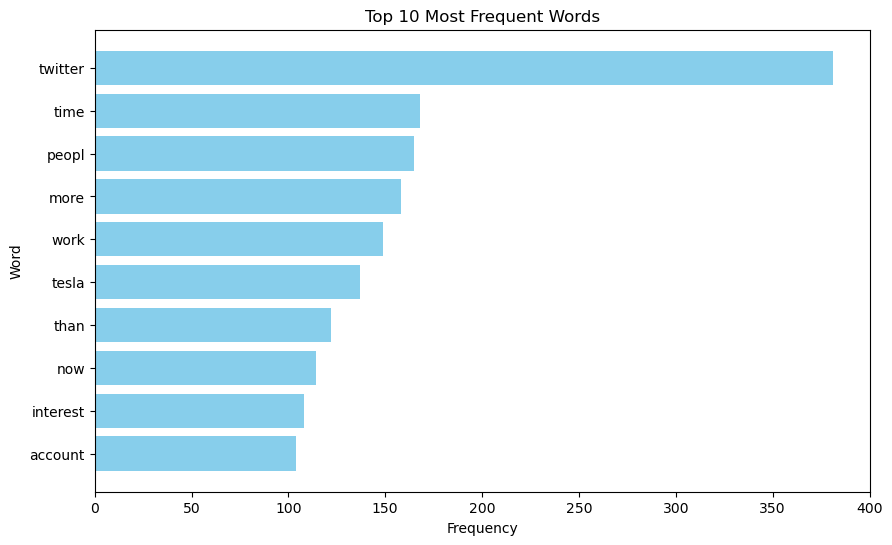

In [15]:
# Extract the top 10 words and their frequencies for plotting
top_words = [pair[0] for pair in sorted_word_freq_pairs[:10]]
top_freqs = [pair[1] for pair in sorted_word_freq_pairs[:10]]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_freqs, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.title('Top 10 Most Frequent Words')
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent word at the top
plt.show()


In [16]:
distinct_user_description = tweets['user_description'].unique()
distinct_user_description

array(['Mars & Cars, Chips & Dips', nan, 'Perfume Salesman', 'Chief Twit',
       'Twitter Complaint Hotline Operator', 'State-Affiliated Media',
       'nothing', 'handsome/brilliant'], dtype=object)

In [17]:
distinct_user_name = tweets['user_name'].unique()
distinct_user_name

array(['Elon Musk', 'Mr. Tweet'], dtype=object)

In [18]:
distinct_hashtags = tweets['hashtags'].unique()
distinct_hashtags

array([nan, "['FreeSpeech']", "['deletefacebook']"], dtype=object)

# 3. Clustering

In [19]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.cm as cm


In [20]:
tweets['nostopwords_rootform_text_str'] = tweets['nostopwords_rootform_text'].apply(lambda x: ' '.join(x))
tweets.head(3)

,id,user_name,user_description,user_followers,date,text,hashtags,retweets,favorites,is_retweet,nostopwords_text,rootform_text,nostopwords_rootform_text,nostopwords_rootform_text_str
0,1544379368478212100,Elon Musk,"Mars & Cars, Chips & Dips",101240855,2022-07-05 17:55:09+00:00,username I find the gold toe sock inevitably o...,NaN,335,6542,False,"[username, I, find, the, gold, toe, sock, inev...","[usernam, i, find, the, gold, toe, sock, inevi...","[find, gold, toe, sock, inevit, off, kilter, w...",find gold toe sock inevit off kilter wash litt...
1,1544377493263720450,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:47:42+00:00,Sock Con the conference for socks,NaN,1451,30753,False,"[Sock, Con, the, conference, for, socks]","[sock, con, the, confer, for, sock]","[sock, con, confer, sock]",sock con confer sock
2,1544377130590552064,Elon Musk,"Mars & Cars, Chips & Dips",101240806,2022-07-05 17:46:15+00:00,Always something new for the magazine cover an...,NaN,1284,28610,False,"[Always, something, new, for, the, magazine, c...","[alway, someth, new, for, the, magazin, cover,...","[alway, someth, new, magazin, cover, articl, p...",alway someth new magazin cover articl practic ...


In [21]:
# Tf idf
tfidf = TfidfVectorizer(
    min_df = 0.00001,
    max_df = 0.95,
    max_features = 3000,
    stop_words = 'english'
)
tfidf.fit(tweets['nostopwords_rootform_text_str'])
tfidf_text = tfidf.transform(tweets['nostopwords_rootform_text_str'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


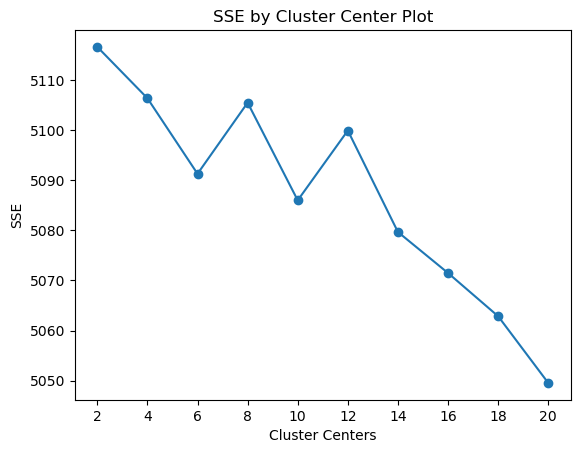

In [22]:
def optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
optimal_clusters(tfidf_text, 20)

In [23]:
# set k to 6
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_text)

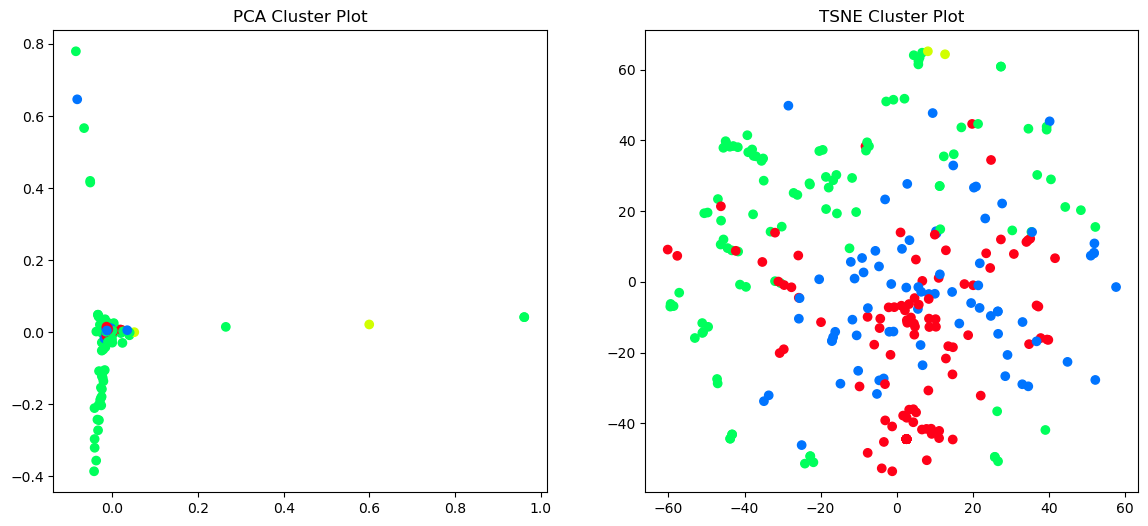

In [24]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    data_array = np.asarray(data[max_items, :].todense())  # Convert matrix to array
    pca = PCA(n_components=2).fit_transform(data_array)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data_array))
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i / max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

plot_tsne_pca(tfidf_text, clusters)

In [25]:
# top keywords based on their TFIDF score to see if we can spot any trends
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(tfidf_text, clusters, tfidf.get_feature_names_out(), 15)


Cluster 0
futil,futur,fwiw,gainoffunct,galaxi,game,gamechang,gap,fuel,fruit,use,matter,energi,comput,unit

Cluster 1
way,everyth,fun,wors,step,tough,miss,complet,ancient,work,chang,live,happen,everi,time

Cluster 2
week,lol,mayb,account,tweet,correct,year,real,time,concern,question,tesla,peopl,work,twitter

Cluster 3
wow,free,bot,doe,yike,engin,tbh,civil,futur,ai,oh,alway,inde,import,thread

Cluster 4
fundament,futur,fwiw,gainoffunct,galaxi,game,gamechang,gap,futil,zone,say,theyr,tell,command,obey

Cluster 5
someth,platform,hear,space,fine,wellsaid,fals,let,love,list,word,definit,best,welcom,starlink


***Comment:*** We observe that the clustering is not the best idea in case of multiple acronyms, slang or proper names.

# 4. NER

In [26]:
import nltk
from nltk.tag import pos_tag
from collections import Counter
from collections import defaultdict

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\karla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
wordlist2 = []

# Iterate over each entry in the 'rootform_text' column and split the text into words
for text in tweets['rootform_text']:
    wordlist2.extend(text)

# Tagging
wordlist2 = nltk.pos_tag(wordlist2)
wordlist2[:10]

[('usernam', 'JJ'),
 ('i', 'NN'),
 ('find', 'VBP'),
 ('the', 'DT'),
 ('gold', 'NN'),
 ('toe', 'NN'),
 ('sock', 'NN'),
 ('inevit', 'NN'),
 ('off', 'IN'),
 ('kilter', 'NN')]

In [28]:
# spaCy English model
nlp = spacy.load('en_core_web_sm')

In [29]:
label_counts = Counter()

# Iterate over each tweet in the DataFrame
for tweet in tweets['text']:
    doc = nlp(tweet)
    labels = [ent.label_ for ent in doc.ents]
    label_counts.update(labels)

print(label_counts)

Counter({'ORG': 1013, 'PERSON': 821, 'DATE': 440, 'CARDINAL': 378, 'GPE': 357, 'PRODUCT': 221, 'NORP': 160, 'LOC': 99, 'TIME': 55, 'ORDINAL': 42, 'WORK_OF_ART': 29, 'QUANTITY': 19, 'EVENT': 17, 'FAC': 14, 'LAW': 10, 'LANGUAGE': 9, 'MONEY': 7, 'PERCENT': 2})


In [30]:
# Initialize a defaultdict to store examples for each entity category
entity_examples = defaultdict(list)

for tweet in tweets['text']:

    doc = nlp(tweet)
    for ent in doc.ents:
        entity_examples[ent.label_].append(ent.text)
        
for label, examples in entity_examples.items():
    print(f'Entity Category: {label}')
    print(examples[:20])  # Print up to 10 examples for each category
    print()

Entity Category: DATE
['these days', 'later this year', 'recent months', '4680', '1013', 'tomorrow', 'next week', 'next month', 'this year', 'next month', '20 to 30 years', 'next httpstcoaQbFmsHDGn', '70s', '16 years ago', 'next month', 'yesterday', 'past year', 'this year', 'today', 'yesterday']

Entity Category: PERSON
['Moon', 'Flatulence Earther', 'Zip', 'Teslas', 'Tesla', 'Mark', 'Mike Duncan', 'Kids', 'Teslas', 'httpstcoI8l3STHVcY', 'httpstcoy4RBNuJ5Rs', 'Join', 'rem httpstcoB25WNIWBpO', 'Tesla', 'Write', 'Charlie Ergen', 'Demo', 'Austin', 'Teslas', 'Tbh']

Entity Category: CARDINAL
['69', 'zero', '10', 'One', 'about 3', '82', 'httpstco5H34xXlmVV', '2', '12GHz', '100k', '78', 'One', 'About 1000', '2', '1', '36', 'zero', '1000', 'two', 'millions']

Entity Category: LOC
['Mars', 'Mars', 'Earth', 'Mars', 'Earth', 'Mars', 'Magellanic Clouds', 'Earth', 'Mars', 'Earth', 'Earth', 'the moon', 'Intergalactic', 'Earth', 'Earth', 'Mars', 'Earth', 'Mars', 'these Mars Bars', 'North America']


**Comment:** Though this model we can conclude that the most frequently reffered entities are: <br>
- ORG (1013) - we observe both political figures and businesses
- PERSON (821) - references to Tesla or some groups of people with specific beliefs
- DATE (440) - in our case, the dates may refer to the current events, news (political, technological)
- CARDINAL (378) - another instance and confirmation of news/statistics existance in the posts
- GPE (357) - mentioning of the Geopolitical Entities suggests engagement in business geographical development or geopolitics 
- NORP (160) - it is Nationalities or Religious or Political Groups, which is most straightforward confirmation of the hypothesis
- LOC (99) - supposingly related to Elon's investments in space exploration

# 5. Topic modelling

#### 5.1 Non-Negative Matrix Factorization

Let's try on rootfor_text (withstopwords).

In [31]:
tweets['rootform_text_str'] = tweets['rootform_text'].apply(lambda x: ' '.join(x))
tweets.head(3)

tfidf_root = TfidfVectorizer(
    min_df = 0.00001,
    max_df = 0.95,
    max_features = 3000,
    stop_words = 'english'
)

tfidf_text_root = tfidf_root.fit_transform(tweets['rootform_text_str'].values.astype('U'))

In [32]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf_text_root )

NMF(n_components=5, random_state=42)

In [33]:
import random

feature_names = tfidf_root.get_feature_names_out()

for i in range(5):
    random_id = random.randint(0, len(feature_names) - 1)
    print(feature_names[random_id])

modif
palo
variou
gener
deplatform


In [34]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-5:]

In [35]:
feature_names = tfidf_root.get_feature_names_out()

for i in top_topic_words:
    print(feature_names[i])

agre
great
absolut
thi
usernam


In [36]:
# print the five words with highest probabilities for each of the topics

feature_names = tfidf_root.get_feature_names_out()

for i,topic in enumerate(nmf.components_):
    print(f'Top five words for topic #{i}:')
    print([feature_names[i] for i in topic.argsort()[-5:]])
    print('\n')

Top five words for topic #0:
['agre', 'great', 'absolut', 'thi', 'usernam']


Top five words for topic #1:
['actual', 'lol', 'veri', 'usernam', 'true']


Top five words for topic #2:
['right', 'rule', 'haha', 'usernam', 'exactli']


Top five words for topic #3:
['sigh', 'bizarr', 'great', 'usernam', 'yeah']


Top five words for topic #4:
['idea', 'point', 'thread', 'question', 'good']




Now let's perform on nostopwords column.

In [37]:
nmf = NMF(n_components=5, random_state=42)
nmf.fit(tfidf_text)

NMF(n_components=5, random_state=42)

In [38]:
feature_names = tfidf.get_feature_names_out()

for i in range(5):
    random_id = random.randint(0, len(feature_names) - 1)
    print(feature_names[random_id])
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-5:]

alexand
section
print
horribl
la


In [39]:
for i in top_topic_words:
    print(feature_names[i])
# print the five words with highest probabilities for each of the topics

account
tweet
time
peopl
twitter


In [40]:
for i,topic in enumerate(nmf.components_):
    print(f'Top five words for topic #{i}:')
    print([feature_names[i] for i in topic.argsort()[-6:]])
    print('\n')

Top five words for topic #0:
['world', 'account', 'tweet', 'time', 'peopl', 'twitter']


Top five words for topic #1:
['fix', 'everi', 'tesla', 'time', 'team', 'work']


Top five words for topic #2:
['wow', 'address', 'super', 'real', 'extrem', 'concern']


Top five words for topic #3:
['inde', 'mayb', 'answer', 'ask', 'real', 'question']


Top five words for topic #4:
['ad', 'comment', 'point', 'import', 'correct', 'thread']




#### 5.2 Bertopic model

In [41]:
text_cleaned = tweets['nostopwords_rootform_text_str']

In [42]:
tokenizer = RegexpTokenizer(r'\w+') # tokenizer
tf_vectorizer = CountVectorizer(encoding = 'utf-8', 
                                decode_error = 'strict', 
                                lowercase = True, # all letters to lower case 
                                ngram_range = (1, 3), # what kind of ngrams do we want 
                                max_df = 0.8, # filtering with document frequency
                                min_df = 2, # filtering with document frequency
                                max_features = None, 
)

tf = tf_vectorizer.fit_transform(text_cleaned)
tf_feature_names = tf_vectorizer.get_feature_names_out() 

In [43]:
topic_model = BERTopic(language="english", vectorizer_model=tf_vectorizer, calculate_probabilities=True, verbose=True, min_topic_size = 2, nr_topics = 20)
topics, probs = topic_model.fit_transform(text_cleaned)

2024-02-29 20:08:54,033 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/185 [00:00<?, ?it/s]

2024-02-29 20:09:24,864 - BERTopic - Embedding - Completed ✓
2024-02-29 20:09:24,865 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-29 20:09:50,786 - BERTopic - Dimensionality - Completed ✓
2024-02-29 20:09:50,788 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-29 20:14:09,010 - BERTopic - Cluster - Completed ✓
2024-02-29 20:14:09,012 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-29 20:14:09,603 - BERTopic - Representation - Completed ✓
2024-02-29 20:14:09,604 - BERTopic - Topic reduction - Reducing number of topics
2024-02-29 20:14:09,903 - BERTopic - Topic reduction - Reduced number of topics from 586 to 20


In [44]:
# display a set of unique topic numbers
print(set(topics))  

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, -1}


In [45]:
# Get topic information
topic_info = topic_model.get_topic_info()

# Extracting words from all topics
all_words = []
for index, row in topic_info.iterrows():
    words = row['Representation']
    all_words.extend(words)

# Count the frequency of each word
word_counts = Counter(all_words)

# Identify and print repetitive words
print("Repetitive Words:")
for word, count in word_counts.items():
    if count > 1:  # Adjust this threshold as needed
        print(f"Word: {word}, Count: {count}")
        
topic_info

Repetitive Words:
Word: twitter, Count: 2
Word: tweet, Count: 2
Word: peopl, Count: 2
Word: more, Count: 2
Word: year, Count: 2
Word: other, Count: 2
Word: time, Count: 2
Word: team, Count: 2
Word: , Count: 5


,Topic,Count,Name,Representation,Representative_Docs
0,-1,1034,-1_twitter_tweet_peopl_more,"[twitter, tweet, peopl, more, now, than, year,...",[twitter improv releas now bookmark tweet twee...
1,0,2463,0_twitter_interest_peopl_account,"[twitter, interest, peopl, account, more, mayb...","[love when peopl complain twitter twitter, twi..."
2,1,1408,1_work_time_thread_import,"[work, time, thread, import, question, correct...","[mess up, fix work, sound mess up]"
3,2,666,2_tesla_starlink_starship_launch,"[tesla, starlink, starship, launch, car, space...",[congrat giga shanghai millionth car total tes...
4,3,82,3_chang_digit_rate_japan,"[chang, digit, rate, japan, biolog, scale, com...",[ratio total digit total biolog comput key met...
5,4,40,4_children_adult_parent_kid,"[children, adult, parent, kid, child, age, nam...",[assist suicid someon matur adult definit kid ...
6,5,36,5_eat_product_donut_caffein,"[eat, product, donut, caffein, joy, sugar, tbh...","[product bring joy rare, after 1 eat sugar htt..."
7,6,30,6_assess_fate_critic_hate,"[assess, fate, critic, hate, analysi, fact, lo...","[assess, assess, fate love ironi hate hypocrisi]"
8,7,30,7_hair_ironi_iron_fire,"[hair, ironi, iron, fire, sold, oh, static fir...","[work burnt hair, over 5000 bottl burnt hair s..."
9,8,19,8_tunnel_dig_grave_sock,"[tunnel, dig, grave, sock, open sourc, open, s...","[tunnel, risk brag littl incred job dig own gr..."


In [46]:
print("Number of topics:", len(topics))
print("Number of documents:", len(text_cleaned))

Number of topics: 5904
Number of documents: 5904


In [47]:
# Print words associated with the first few topics
for i in range(min(5, len(topic_model.get_topics()))):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

Topic 0: [('twitter', 0.0322282863033962), ('interest', 0.020113838748801325), ('peopl', 0.01888339455536882), ('account', 0.016640219282088746), ('more', 0.01529936348367797), ('mayb', 0.013350177426517095), ('tweet', 0.012863580759799563), ('their', 0.012529397883623554), ('real', 0.012202096235945674), ('get', 0.012105203625089309)]
Topic 1: [('work', 0.04619314072529063), ('time', 0.0420417321960879), ('thread', 0.03833102446436863), ('import', 0.03457314463976743), ('question', 0.03437472911053642), ('correct', 0.03219806055006965), ('point', 0.030132932365736075), ('probabl', 0.02947211820405071), ('up', 0.02872985527396465), ('idea', 0.028222460255567784)]
Topic 2: [('tesla', 0.08090496961999379), ('starlink', 0.04672350895234232), ('starship', 0.04104249025087688), ('launch', 0.03986475635749693), ('car', 0.03211930303872821), ('spacex', 0.025529078610445725), ('earth', 0.02448130924902795), ('team', 0.023846660933743928), ('year', 0.020998731531686878), ('orbit', 0.02031741988

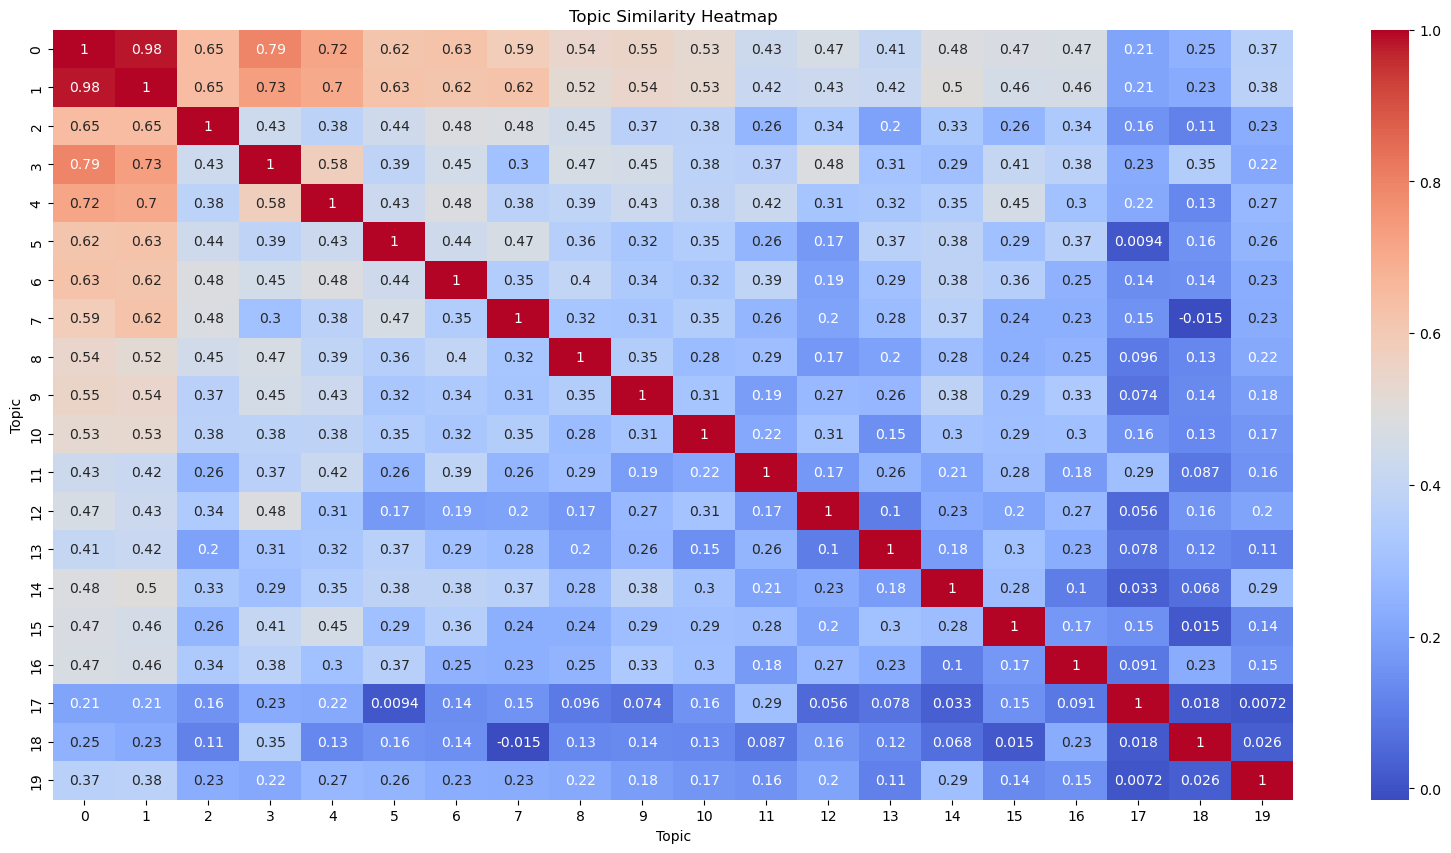

In [48]:
# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(topic_model.topic_embeddings_)

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
plt.title("Topic Similarity Heatmap")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()

A high similarity score (closer to 1, warmer colors) suggests that the topics are closely related and might share a number of keywords or are discussing similar themes. Low scores (closer to 0, cooler colors) suggest that the topics are quite distinct from each other.

In [49]:
topic_model.visualize_barchart()


This bar charts (saved as Plot1)  represent the most relevant words for a selection of topics (Topic 0 to Topic 7) along with their respective scores. The words at the longer end of the bars are the ones that most define the topic and are used to interpret what the topic is about.
For example:
- Topic 0 seems to be about general interest, concerns, and questions, potentially related to work or other matters that elicited a response (noted by "lol").
- Topic 1 is clearly focused on Twitter, mentioning accounts, tweets, and platforms, which may relate to discussions about social media usage.
- Topic 2 might be related to customer engagement or service (with words like "people," "subscribe," "real").
- Topic 3 is centered around Tesla, with references to cars, AI, and the team, likely reflecting discussions about Tesla's products and technological advancements.
- Topic 4 involves SpaceX's projects, as evidenced by words like "starlink," "starship," "launch," and "orbit."

# 6. Conclusion

In this project we attempted to confirm, if Elon Musk in his tweets is referencing mainly to the politics, ai topics, his own businesses and moral issues. We used three approaches clustering, NER and topic modelling. <br>
<br>
In clustering, our model was struggling with the stopwords. Whenever we run the model, the new stopwords appeared as a representatives of the clusters, we added them to the stopwords list and this loop seemed to had no end. Even though if through constantly adding the new slang words, stopwords, abbreviations (...) to our stopwords list we would eventually reach the goal of only the substantial words to be clustered, it is largely time-consuming and uneffective approach.<br><br>
For NER, we were able to create a hierarchy of the words already assigned to some categories (entities). Since the algorithm skipped in advance the words it was unable to clasify, we could focus on the actual entities. In result, the assessment went time-effectively and the output was easy to interpret. <br><br>
As a result of Topic modeling, it was easier to categorize the output to some patent group (topic), but still the output wasn't straightforward and one could have some doubts.<br><br>
Our assessment helped us to verify, that NER might be the appropriate model when we work on the data with a lot of daily-use words, neologism or slang and our purpose is to extract the topics that are commonly raised in the document. According to NER, Elon Musk's tweets are frequently refer to organizations, people, dates, cardinal (statistics), geopolitics, products (among the others, those related to the space business), nationalities or religious or political groups, locations. Although those categories are strictly the topics that the Twitter is known from, if we will take a closer look for the instances of those entities, we will see Tesla, Twitter, Starlink, Trump, planets, space business, different representativess of social groups and so on - which are strictly related to Musk. It can be the initial stage of confirming our hypothesis.

# 7.Appendix

Fullform word finder - while rootforms of the worlds are provided in the models' outputs, it might be hard to interpret them and drag a conclusions. For this reason, I have created this searching tool, which wil provide us an instance of the searching world in the original text.

In [50]:
# Find '...' in the 'rootform_text' column
occurrences = [i for i, rootform_text in enumerate(tweets['rootform_text']) if 'donat' in rootform_text]

# Get the 'rootform_text' and 'text' for each occurrence
rootform_texts = [tweets['rootform_text'].iloc[i] for i in occurrences]
original_texts = [tweets['text'].iloc[i] for i in occurrences]

for rootform_text, original_text in zip(rootform_texts, original_texts):
    print("Rootform Text:", rootform_text)
    print("Original Text:", original_text)
    print()


Rootform Text: ['ok', 'we', 'will', 'add', 'a', 'donat', 'option', 'to', 'starlink']
Original Text: Ok we will add a donate option to Starlink

Rootform Text: ['are', 'there', 'other', 'that', 'want', 'to', 'donat', 'starlink', 'to', 'place', 'in', 'need', 'httpstcom0asmenmrd']
Original Text: Are there others that want to donate Starlinks to places in need httpstcoM0ASMenMRD

Rootform Text: ['usernam', 'im', 'still', 'confus', 'as', 'to', 'how', 'a', 'nonprofit', 'to', 'which', 'i', 'donat', '100m', 'somehow', 'becam', 'a', '30b', 'market', 'cap', 'httpstcodbtfmv4vcv']
Original Text: username Im still confused as to how a nonprofit to which I donated 100M somehow became a 30B market cap httpstcoDBtfMV4VCV

Rootform Text: ['usernam', 'i', 'donat', 'the', 'first', '100m', 'to', 'openai', 'when', 'it', 'wa', 'a', 'nonprofit', 'but', 'have', 'no', 'ownership', 'or', 'control']
Original Text: username I donated the first 100M to OpenAI when it was a nonprofit but have no ownership or contro